## Image segmentation with Road

In [ ]:
!nvidia-smi

Sun Jul 19 22:23:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path

In [ ]:
path=Path("drive/My Drive/roads")

In [ ]:
path_lbl = path/'roads/mask'
path_img = path/'roads/img'

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[19]

PosixPath('drive/My Drive/roads/roads/img/21.png')

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:10]

[PosixPath('drive/My Drive/roads/roads/mask/02.png'),
 PosixPath('drive/My Drive/roads/roads/mask/12.png'),
 PosixPath('drive/My Drive/roads/roads/mask/09.png'),
 PosixPath('drive/My Drive/roads/roads/mask/15.png'),
 PosixPath('drive/My Drive/roads/roads/mask/01.png'),
 PosixPath('drive/My Drive/roads/roads/mask/18.png'),
 PosixPath('drive/My Drive/roads/roads/mask/06.png'),
 PosixPath('drive/My Drive/roads/roads/mask/10.png'),
 PosixPath('drive/My Drive/roads/roads/mask/03.png'),
 PosixPath('drive/My Drive/roads/roads/mask/11.png')]

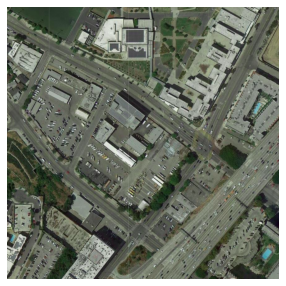

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [ ]:
import cv2
# start = time.time()

img = cv2.imread('drive/My Drive/roads/roads/mask/01.png')



In [ ]:
import numpy as np
np.unique(img)

array([0, 1], dtype=uint8)

In [ ]:
(unique, counts) = np.unique(img, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[      0 1520013]
 [      1 1625715]]


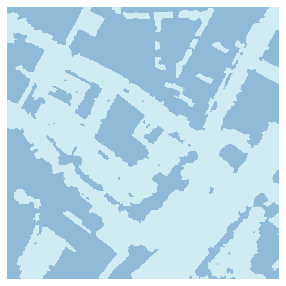

In [ ]:
mask = open_mask('drive/My Drive/roads/roads/mask/01.png')
mask.show(figsize=(5,5))

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1024, 1024]), tensor([[[0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [ ]:
np.unique(mask.data)

array([0, 1])

In [ ]:
(unique, counts) = np.unique(mask.data, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[     0 506671]
 [     1 541905]]


In [ ]:

codes =['var','roads']

In [ ]:
#     various = 0:0:0    :0==2==7==6
#     building = 128:0:0 :1==8
#     door = 128:128:0   :2
#     pavement = 128:128:128  :3
#     road = 128:64:0     :4
# 

In [ ]:
codes=np.array(codes)

In [ ]:
codes

array(['var', 'roads'], dtype='<U5')

## Datasets

In [ ]:
size = src_size//2
# size = src_size//2
# bs=2
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [ ]:
bs=2

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

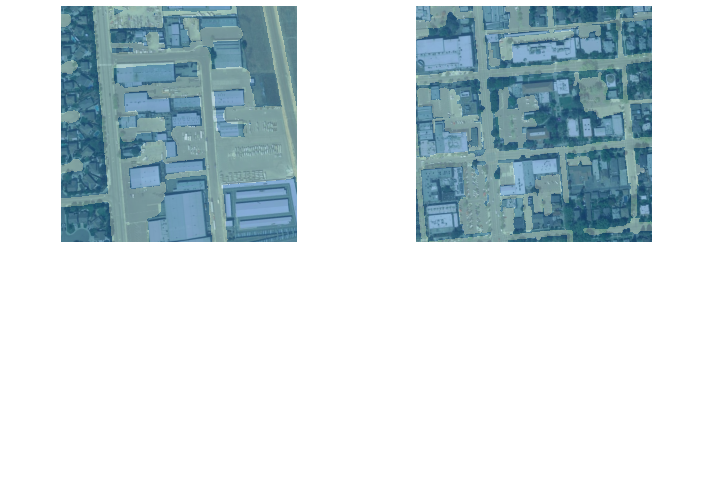

In [ ]:
data.show_batch(2, figsize=(10,7))

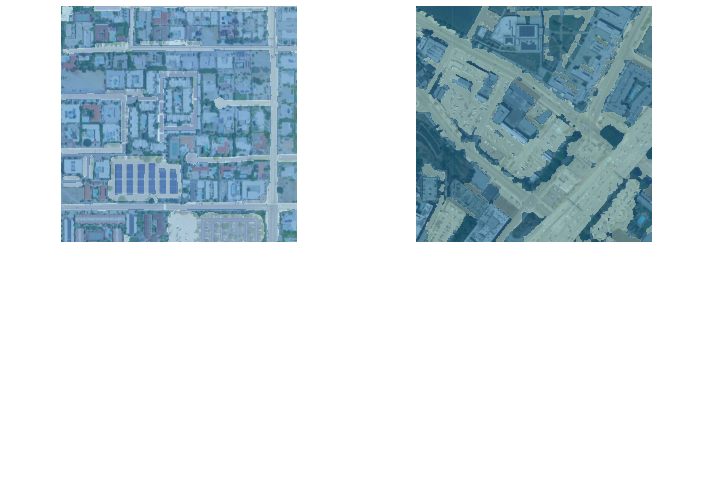

In [ ]:

data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
# name2id = {v:k for k,v in enumerate(codes)}


def accuracy(input, target):
    #The input.argmax(dim=1) selects the winner class pr pixel, thereby reducing 
    #the input shape from (bs, classes, width, height) => (bs, width, height)
    #We, therefore, have to reshape the target tensor from (bs, 1, width, height) to (bs, width, height)
    sz     = target.size()
    target = target.reshape( (sz[0],sz[2],sz[3]) )
    return (input.argmax(dim=1).flatten()==target.flatten()).float().mean()

In [ ]:

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        # print(output.shape)
        channels = output.shape[1]
        # print(channels),print(len(self.ch_wts))
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        # counter1=0
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            # counter=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs):

              # print(ch_wt,c,output[:,c,None].shape),print(ch_wt,c,target[:,0,None].shape)
              ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,0,None])
              # print(ch_loss)
              # counter+=1
            # counter1+=1
            loss+=ch_wt*(ch_loss)
            # print(loss)
        return loss/sum(self.ch_wts)

In [ ]:
# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,0,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh).byte()==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,0,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [ ]:
metrics=accuracy
# acc_ch0 = partial(acc_thresh_multich, one_ch=1)
# dice_ch0 = partial(dice_multich, one_ch=1)
# metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [ ]:
learn = unet_learner(data, models.resnet34, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1])
                    )

KeyboardInterrupt: ignored

In [ ]:
wd=0.01

In [ ]:

learn = unet_learner(data, models.resnet34, wd=wd,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


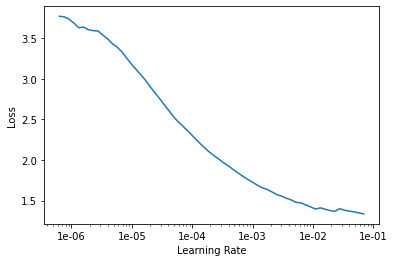

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=0.0001

In [ ]:
learn.fit_one_cycle(12, slice(lr), moms=(0.95,0.85))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
# learn.export()

In [ ]:
lr=0.00001

In [ ]:
learn.fit_one_cycle(6, slice(lr), moms=(0.95,0.85))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2');

In [ ]:
#lr=0.00001

In [ ]:
#learn.fit_one_cycle(4, slice(lr), moms=(0.95,0.85))

In [ ]:
#learn.save('stage-2')

In [ ]:
#learn.load('stage-2');

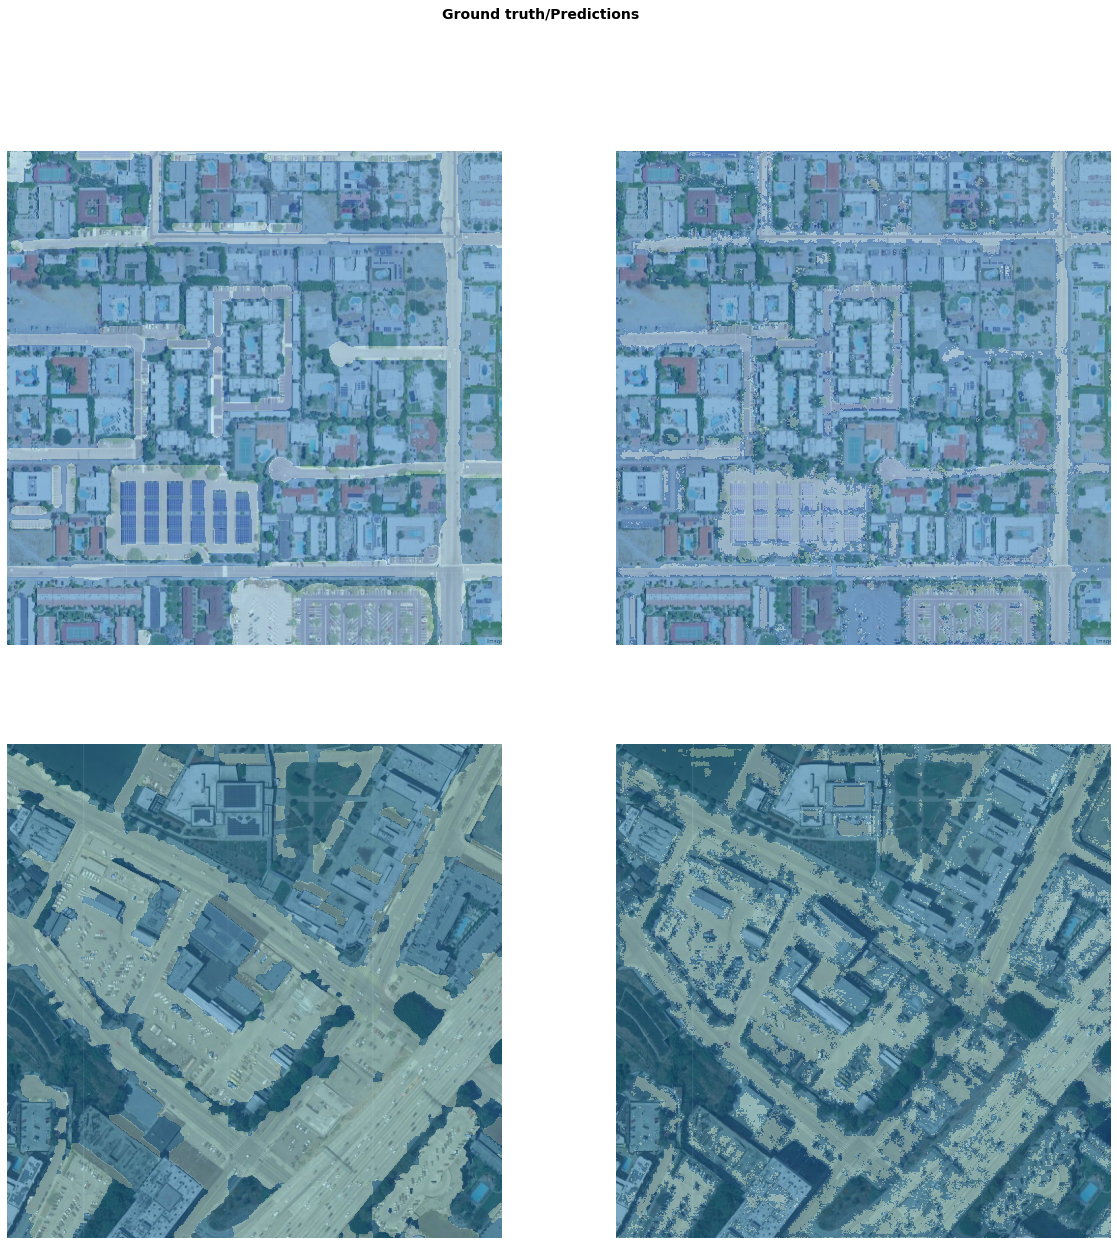

In [ ]:
learn.show_results(rows=3, figsize=(20,20))

In [ ]:

learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


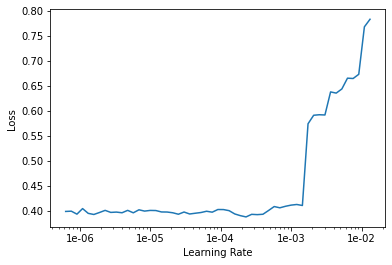

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=0.000001

In [ ]:
lrs = slice(lr/600,lr/6)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.3)

In [ ]:
learn.save('stage-3');


In [ ]:
learn.load('stage-3');

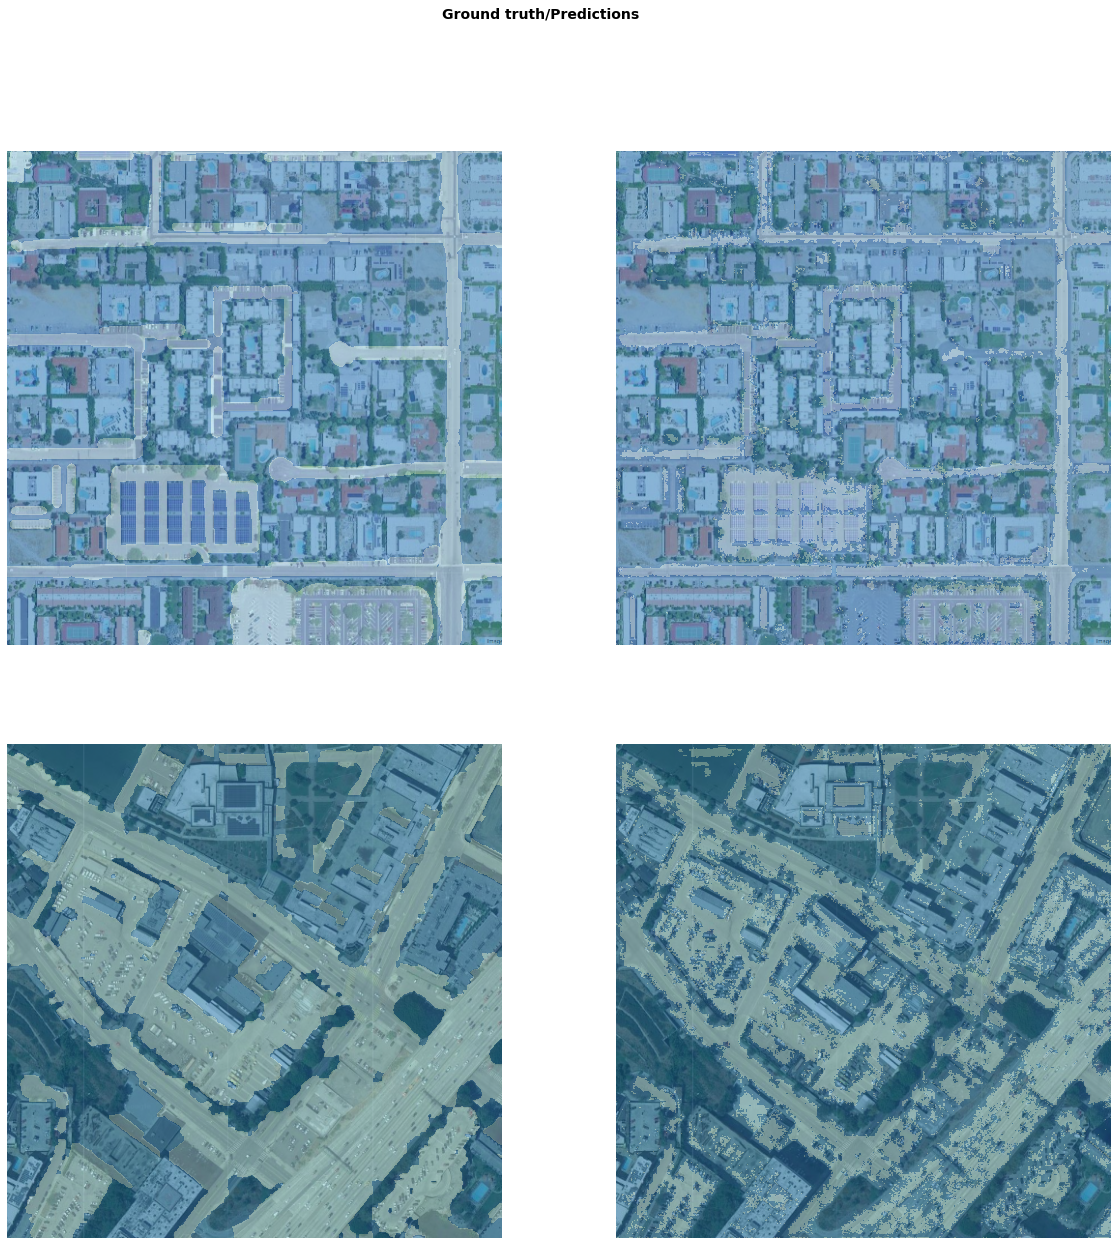

In [ ]:
learn.show_results(rows=3, figsize=(20,20))

torch.Size([1, 512, 512])

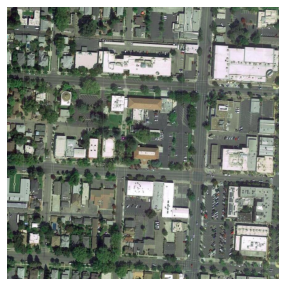

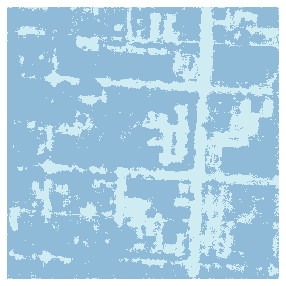

In [ ]:
img = open_image(fnames[1])
img.show(figsize=(5,5))
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))
(prediction[0]).shape

In [ ]:
prediction[0].data

tensor([[[0, 1, 1,  ..., 1, 1, 1],
         [0, 1, 1,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])

In [ ]:
np.unique(prediction[0].data)

array([0, 1])

In [ ]:
(unique, counts) = np.unique(prediction[0].data, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[     0 124689]
 [     1 137455]]


## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()


this Learner object self-destroyed - it still exists, but no longer usable


In [ ]:

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 11430MB of GPU RAM free


In [ ]:
bs=1

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:

learn = unet_learner(data, models.resnet34, wd=wd,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn = unet_learner(data, models.resnet34, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1])
                    )

In [ ]:
!nvidia-smi

Mon Jul  6 18:39:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |    955MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
learn.load('stage-3');

In [ ]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


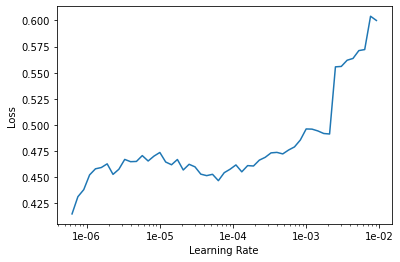

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-7

In [ ]:
learn.fit_one_cycle(7, slice(lr))

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


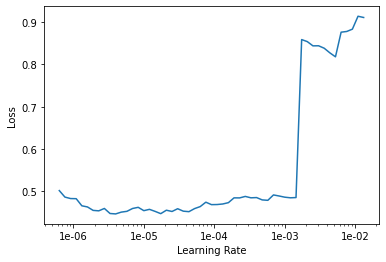

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-7

In [ ]:
learn.fit_one_cycle(7, slice(lr))

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
#fnames[19]

torch.Size([1, 1024, 1024])

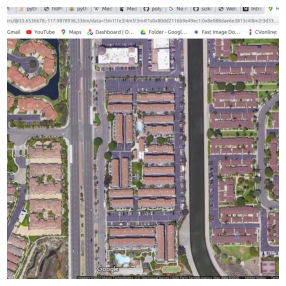

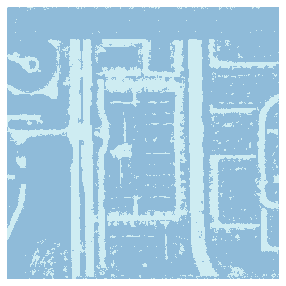

In [ ]:
img = open_image('drive/My Drive/roads/Selection_073.png')
img.show(figsize=(5,5))
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))
(prediction[0]).shape

In [ ]:
lr=1e-5

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

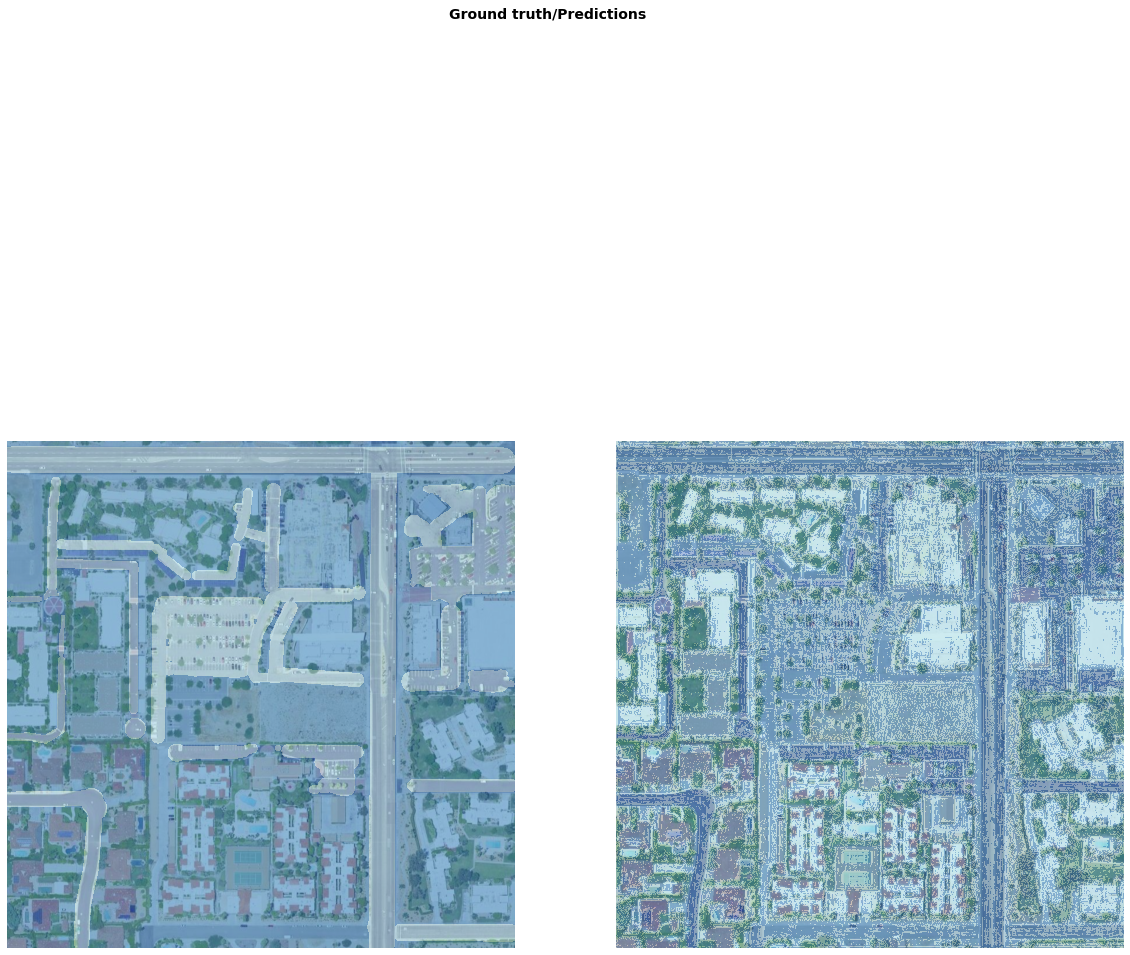

In [ ]:
learn.show_results(rows=5, figsize=(20,20))

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


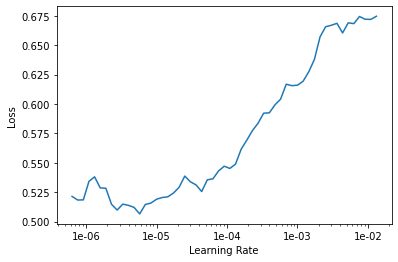

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-6

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.save('stage-3-big')

In [ ]:
learn.load('stage-3-big');

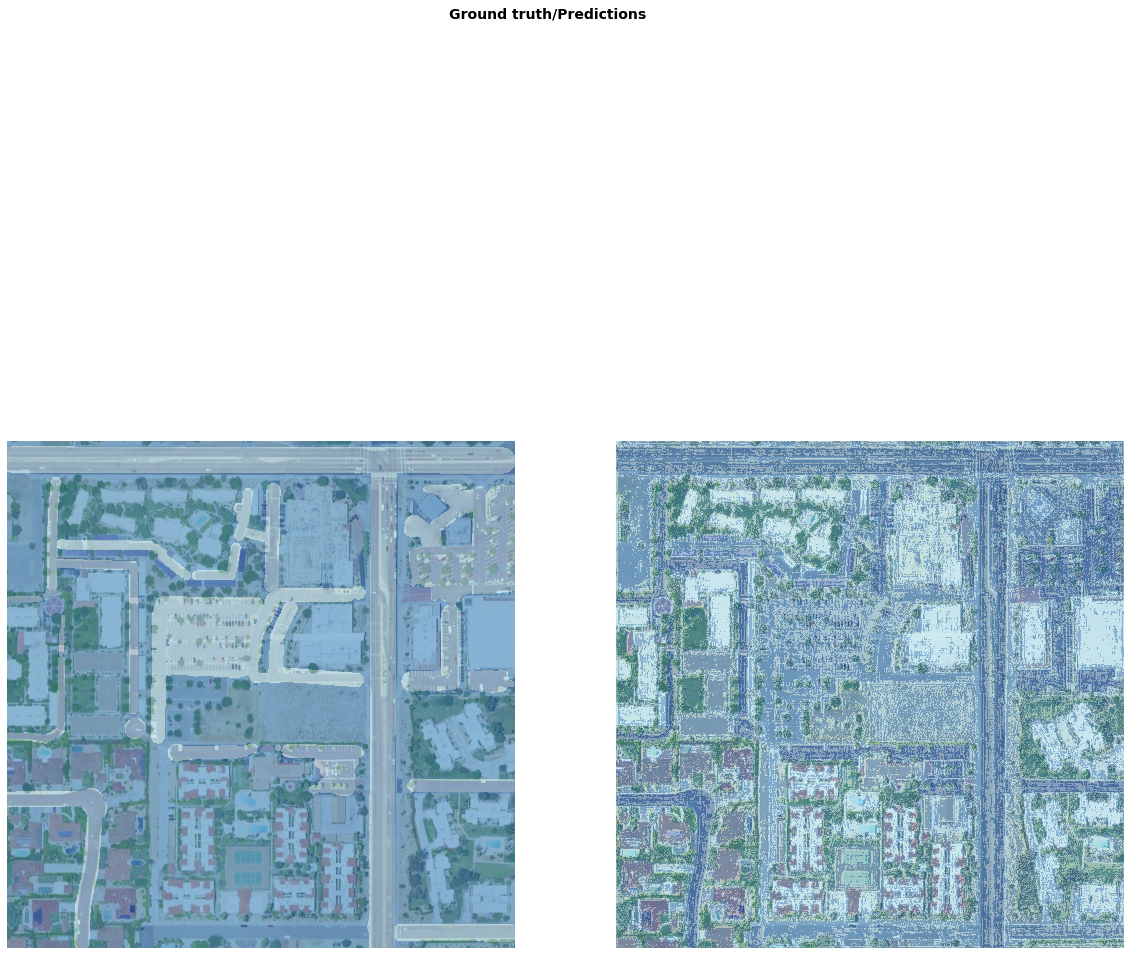

In [ ]:
learn.show_results(rows=3, figsize=(20,20))

In [ ]:
curr=4

## fin